In [1]:
from orange_peels import OrangePeelsDataset
from orange_peels import Constants as c
import utils
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy
import json
import os

# Image Pre-processing
With PyTorch's `transforms` module, we perform the necessary pre-processing steps.
- `Resize`: resizes the image
- `Normalize`: normalizes the image to match the ResNet50 mean and standard deviation

In [2]:
transform = transforms.Compose([
    transforms.Resize((int(c.IMG_SIZE[0]*c.IMG_MAG), int(c.IMG_SIZE[1]*c.IMG_MAG))),
    transforms.Normalize(mean=c.RESNET_MEAN, std=c.RESNET_STD)
])

inv_transform = transforms.Compose([
    transforms.Normalize(mean = [0., 0., 0.,], std = [1/sd for sd in c.RESNET_STD]),
    transforms.Normalize(mean = [-m for m in c.RESNET_MEAN], std = [1., 1., 1.]),
    # transforms.ColorJitter(contrast=1/0.01),
])

# Loading the Data
We load the data such that each class is represented equally.

In [3]:
source = "./data_orange_peels_white_red/"
for subdir in os.listdir(source):
    length = len([f for f in os.listdir(source+subdir) if f.startswith("IMG")])
    print(f"Class {subdir}: {length}")

Class 10: 187
Class 15: 143
Class 20: 231
Class 6: 136


In [4]:
# source = deepcopy(c.IMG_DIR)
# source = "./data_orange_peels_contrast_1.5"
data = OrangePeelsDataset(source, class_size=131, transform=transform, stats=True) # 91 is the max. class size for the 6 years class

Class: 10	Available: 187		Added: 131
Class: 15	Available: 143		Added: 131
Class: 20	Available: 231		Added: 131
Class: 6	Available: 136		Added: 131
		Total: 697		Total: 524


We can randomly select an image and display it to see how it looks.

**NOTE:** We apply an inverse transform first to view the image before normalization.

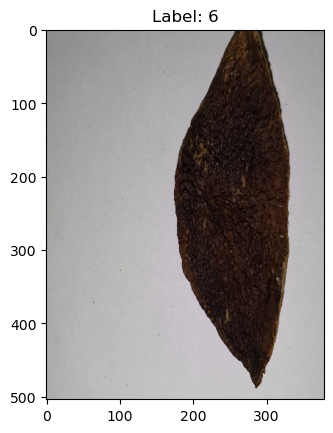

Shape: torch.Size([3, 504, 378]) (1)


In [5]:
img = data[random.randint(0, len(data))]
utils.view_image(inv_transform(img[0]), img[1], c.DECODER)
print(f"Shape: {img[0].shape} ({c.IMG_MAG})")

We also set `device` to be the GPU.

In [6]:
device = utils.get_device()

Device: cuda:0


# Training the Model
We select a base model to start from (e.g., ResNet50).

In [7]:
# load resnet50
model_name = "resnet50" 
base = torch.hub.load("pytorch/vision:v0.13.1", model_name, weights="ResNet50_Weights.DEFAULT")

Using cache found in C:\Users\fongc/.cache\torch\hub\pytorch_vision_v0.13.1


We use `sklearn`'s `KFold` object to split the dataset into five folds. Alternatively, **stratified *k*-fold** could be used for a balanced class representation.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_idx, test_idx) in enumerate(skf.split(data.annotations["image_path"], data.annotations["label"])):
    train_loader, test_loader = utils.create_loader(data, train_idx=train_idx, test_idx=test_idx)
    optimizer = torch.optim.Adam
    model, optimizer = utils.create_model(base, optimizer, output_layers=2048, remove_layers=1, device=device)
    # model, optimizer = utils.create_model_inception(base, optimizer, device=device) # for Inception V3 only
    criterion = nn.CrossEntropyLoss()
    train_loss, train_acc, test_acc = utils.train_model(model, train_loader, test_loader, optimizer, criterion, device=device, stats=True)
    pred, true = utils.test_model(model, test_loader, device=device, save=True)
    utils.results_to_json(f"{model_name}_{i}.json", train_loss, train_acc, test_acc, pred, true)

In [8]:
train_loader, test_loader = utils.create_loader(data, prop=0.8)
optimizer = torch.optim.Adam
criterion = nn.CrossEntropyLoss()
model, optimizer = utils.create_model(base, optimizer, output_layers=2048, remove_layers=1, device=device)
train_loss, train_acc, test_acc = utils.train_model(model, train_loader, test_loader, optimizer, criterion, device, stats=True)
pred, true = utils.test_model(model, test_loader, device=device, save=True)
utils.results_to_json(f"{model_name}_full_no_kfold_white_red.json", train_loss, train_acc, test_acc, pred, true)

	[B1]	Loss 1.4064, Train 0.1875, Test 0.2190
	[B2]	Loss 1.4126, Train 0.2500, Test 0.2190
	[B3]	Loss 1.3818, Train 0.3125, Test 0.2190
	[B4]	Loss 1.3428, Train 0.3750, Test 0.2095
	[B5]	Loss 1.3650, Train 0.3125, Test 0.2190
	[B6]	Loss 1.4225, Train 0.2500, Test 0.2476
	[B7]	Loss 1.3294, Train 0.3750, Test 0.2762
	[B8]	Loss 1.3971, Train 0.1875, Test 0.3048
	[B9]	Loss 1.3248, Train 0.4375, Test 0.3429
	[B10]	Loss 1.3094, Train 0.5312, Test 0.3333
	[B11]	Loss 1.3127, Train 0.5000, Test 0.3048
	[B12]	Loss 1.2958, Train 0.5312, Test 0.3429
	[B13]	Loss 1.3526, Train 0.3750, Test 0.4095
	[B14]	Loss 1.4797, Train 0.0000, Test 0.3905
[E1]	Loss 1.4797, Train 0.0000, Test 0.3905
	[B15]	Loss 1.2971, Train 0.2812, Test 0.4857
	[B16]	Loss 1.2427, Train 0.5312, Test 0.4857
	[B17]	Loss 1.2818, Train 0.4062, Test 0.5238
	[B18]	Loss 1.1853, Train 0.6250, Test 0.5619
	[B19]	Loss 1.1930, Train 0.7500, Test 0.5714
	[B20]	Loss 1.2979, Train 0.4062, Test 0.6000
	[B21]	Loss 1.1431, Train 0.8125, Test 0.6095

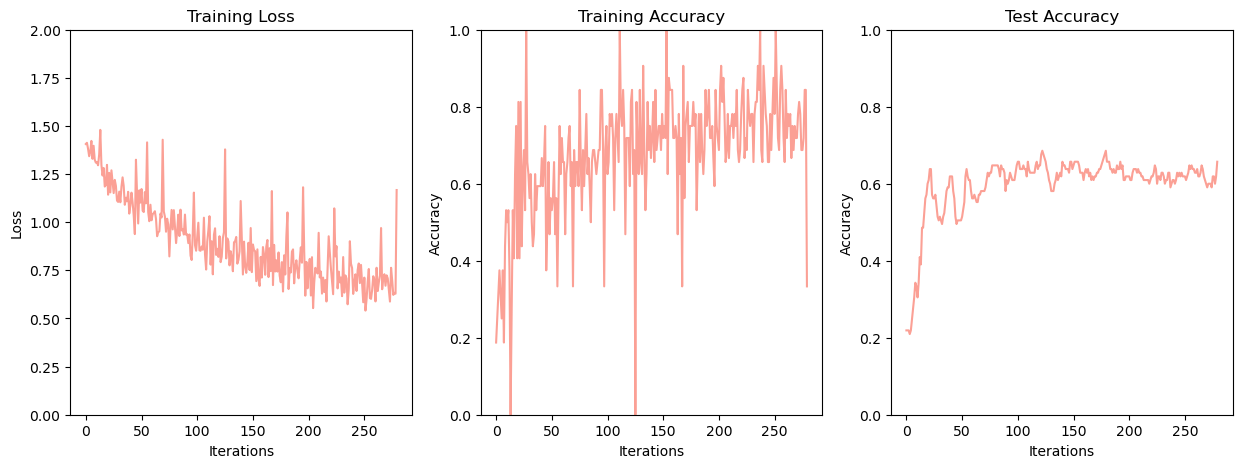

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
utils.plot_loss_acc(axes, train_loss, train_acc, test_acc, label="ResNet50", color="salmon")

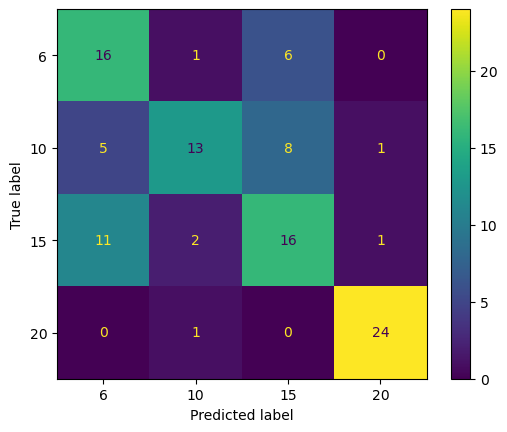

In [12]:
cm, report = utils.generate_metrics(true, pred)

In [13]:
# print report in JSON format with indent
print(json.dumps(report, indent=4))

{
    "0": {
        "precision": 0.5,
        "recall": 0.6956521739130435,
        "f1-score": 0.5818181818181818,
        "support": 23
    },
    "1": {
        "precision": 0.7647058823529411,
        "recall": 0.48148148148148145,
        "f1-score": 0.5909090909090909,
        "support": 27
    },
    "2": {
        "precision": 0.5333333333333333,
        "recall": 0.5333333333333333,
        "f1-score": 0.5333333333333333,
        "support": 30
    },
    "3": {
        "precision": 0.9230769230769231,
        "recall": 0.96,
        "f1-score": 0.9411764705882353,
        "support": 25
    },
    "accuracy": 0.6571428571428571,
    "macro avg": {
        "precision": 0.6802790346907994,
        "recall": 0.6676167471819645,
        "f1-score": 0.6618092691622104,
        "support": 105
    },
    "weighted avg": {
        "precision": 0.6783236371471665,
        "recall": 0.6571428571428571,
        "f1-score": 0.6558645276292334,
        "support": 105
    }
}


In [14]:
# save model
torch.save(model, f"./{model_name}_full_no_kfold_white_red.pt")